In [1]:
import pickle
import os
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from model import ConvNet


Using hyperparameters: reg=0.001, lr=0.01, num_filters1=32, num_filters2=64
Available keys in .npz file: ['w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'gamma1', 'beta1', 'gamma2', 'beta2', 'running_mean1', 'running_var1', 'running_mean2', 'running_var2']


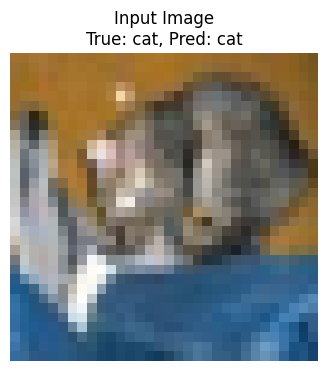

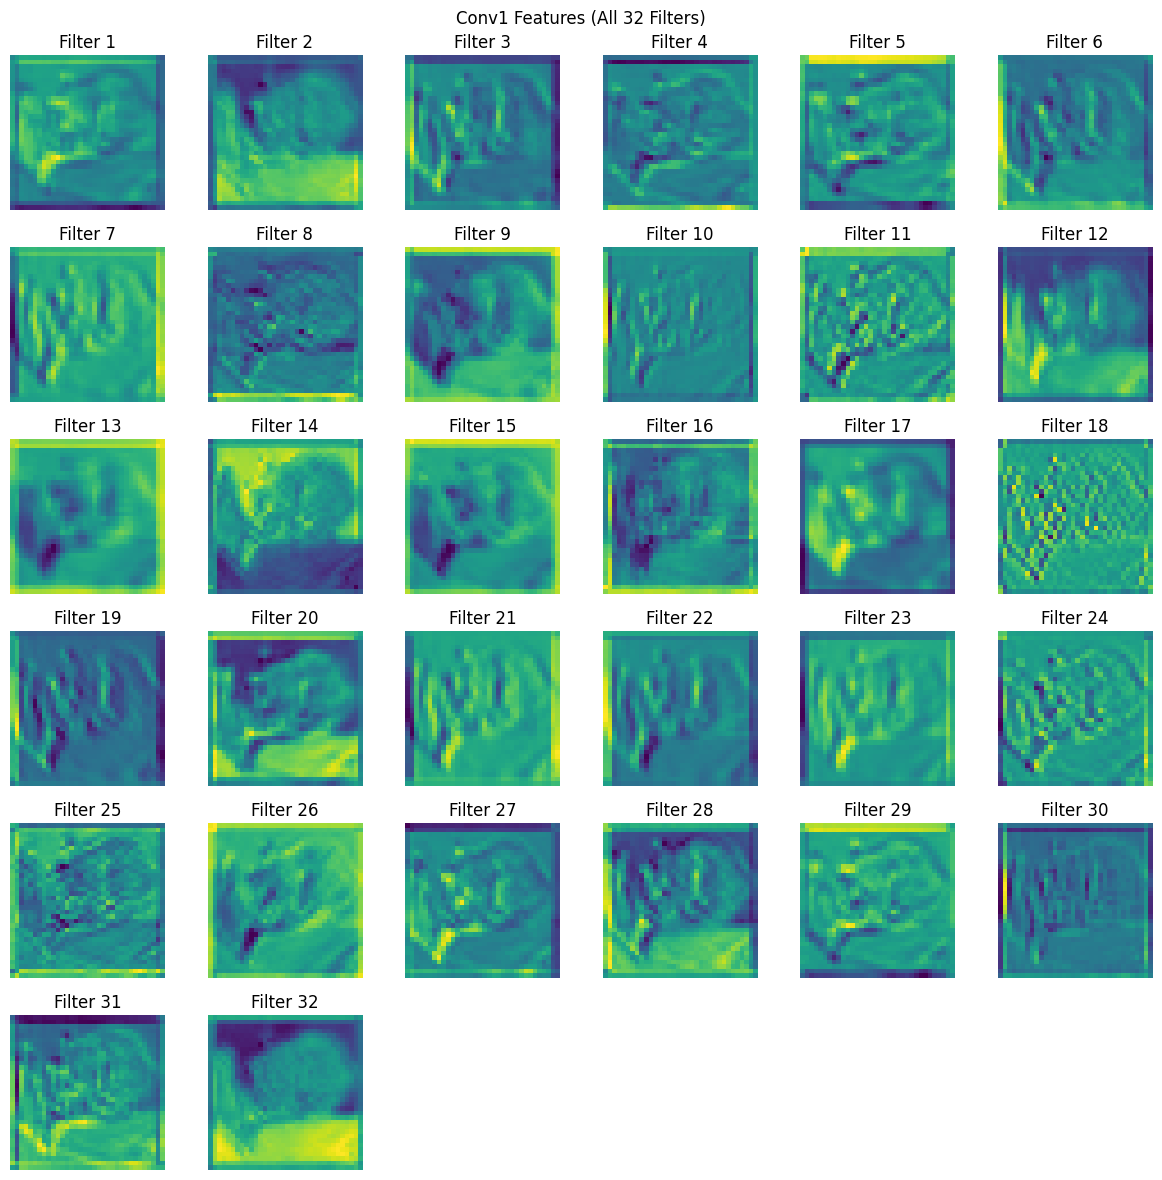

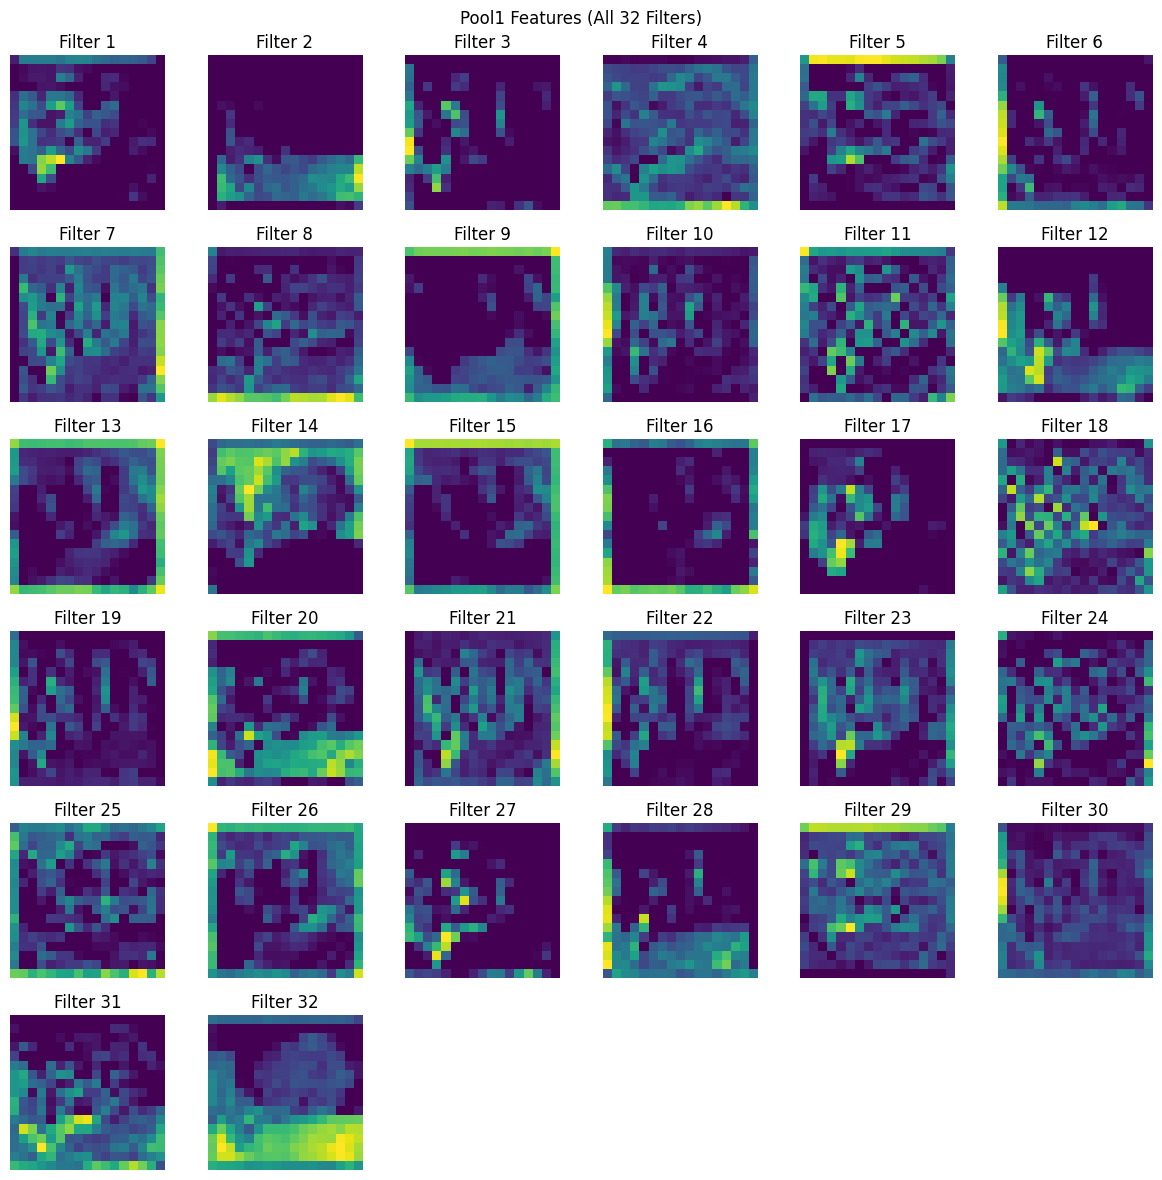

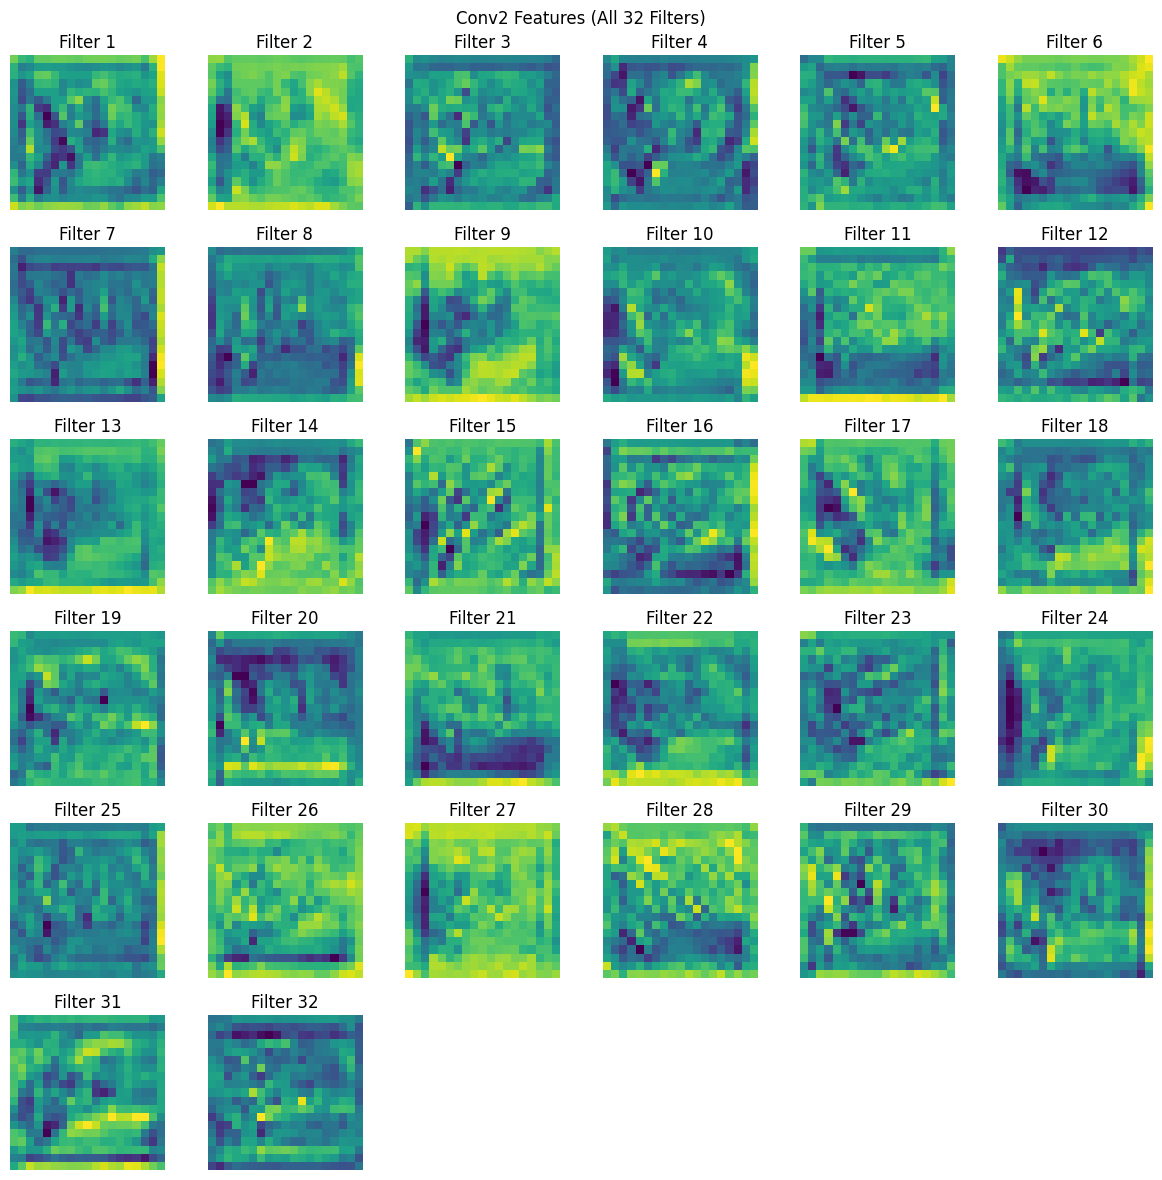

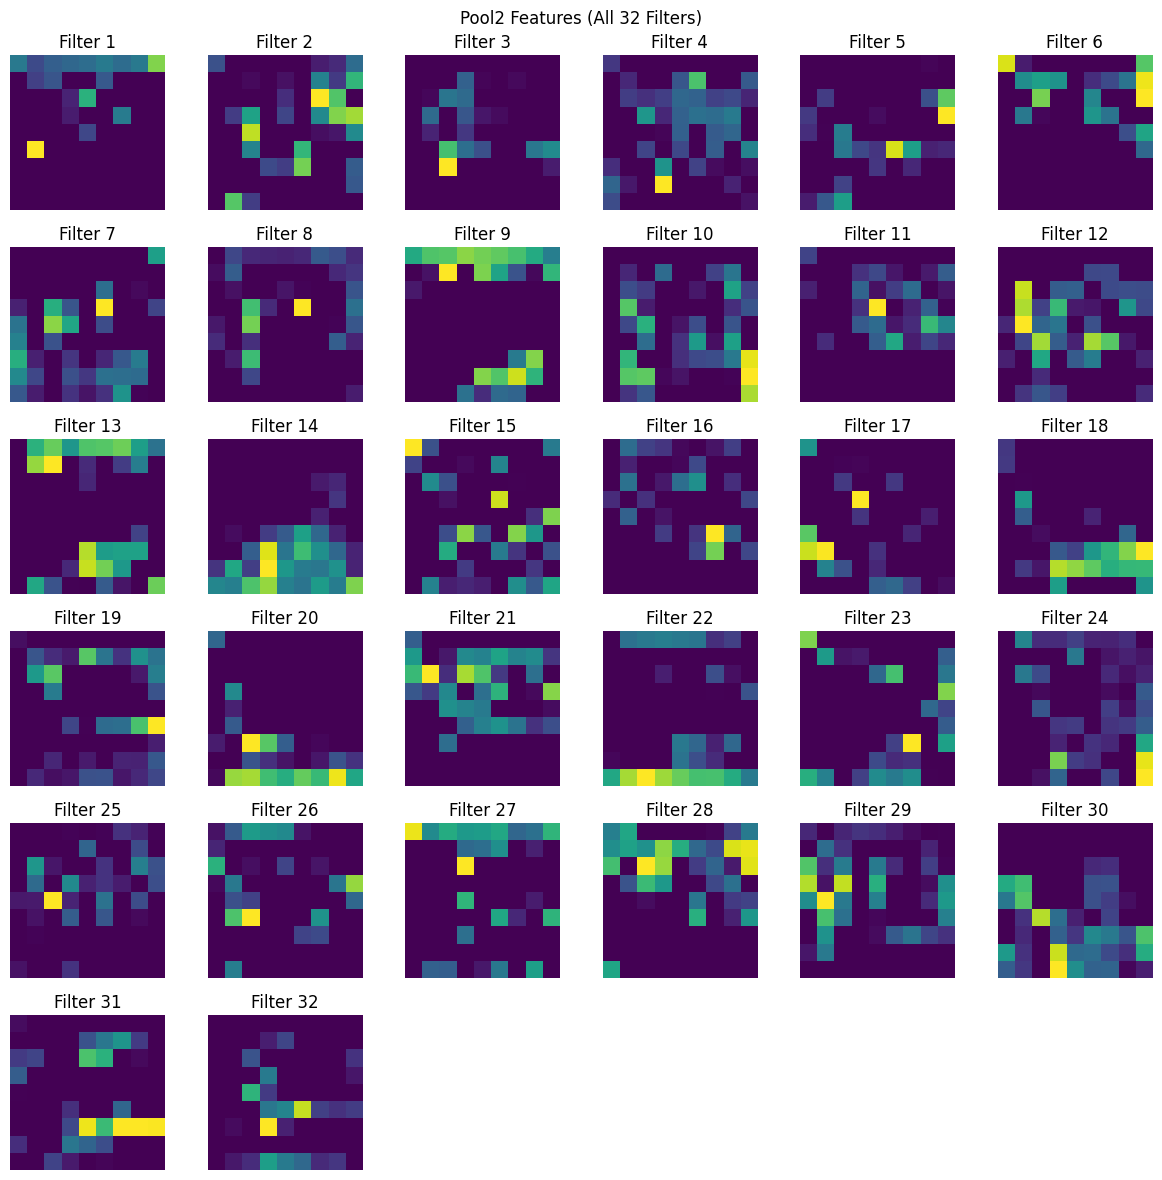

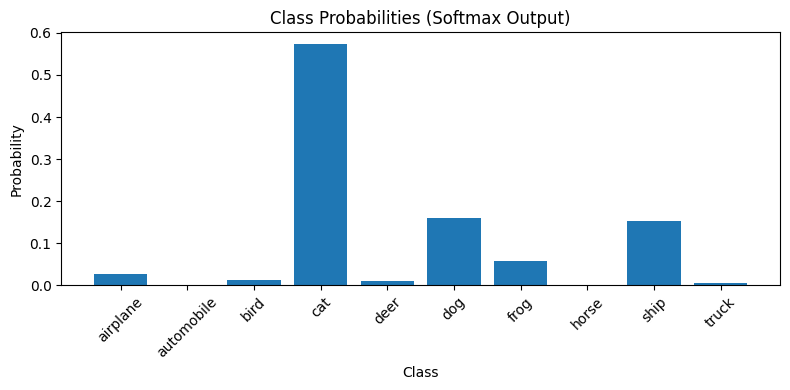

True Label: cat (index: 3)
Predicted Label: cat (index: 3)

Class Probabilities:
airplane: 0.0268
automobile: 0.0014
bird: 0.0134
cat: 0.5728
deer: 0.0092
dog: 0.1590
frog: 0.0588
horse: 0.0012
ship: 0.1521
truck: 0.0054


In [2]:

# Hyperparameters
REG = 0.001  # Regularization strength (example value)
LR = 0.01    # Learning rate (example value)
NUM_FILTERS1 = 32  # Number of filters in first conv layer
NUM_FILTERS2 = 64  # Number of filters in second conv layer

CIFAR10_CLASSES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

def load_cifar10_batch(file):
    with open(file, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    data = batch[b'data'].reshape(-1, 3, 32, 32) / 255.0
    labels = batch[b'labels']
    return data, labels

def visualize_features(features, layer_name):
    """
    Visualize all feature maps for a given layer
    Parameters:
        features: CuPy array of shape (n, c, h, w)
        layer_name: Name of the layer (e.g., 'conv1')
    """
    features = cp.asnumpy(features[0])  
    num_filters = features.shape[0]  

    cols = int(np.ceil(np.sqrt(num_filters)))  
    rows = int(np.ceil(num_filters / cols))

    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(num_filters):
        plt.subplot(rows, cols, i + 1)
        feature_map = features[i]
        # Normalize for visualization
        if feature_map.max() > feature_map.min():  # Avoid division by zero
            feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
        else:
            feature_map = np.zeros_like(feature_map)  # Handle constant feature maps
        plt.imshow(feature_map, cmap='viridis')
        plt.axis('off')
        plt.title(f'Filter {i+1}')
    plt.suptitle(f'{layer_name} Features (All {num_filters} Filters)')
    plt.tight_layout()
    plt.show()

def analyze_single_image(model, image, true_label, model_file):
    """
    Analyze a single image: predict class, show probabilities, visualize all features
    """
    # Load model weights using NumPy and convert to CuPy
    try:
        weights_np = np.load(model_file)
        expected_keys = [
            'w1', 'b1', 'w2', 'b2', 'w3', 'b3',
            'gamma1', 'beta1', 'gamma2', 'beta2',
            'running_mean1', 'running_var1', 'running_mean2', 'running_var2'
        ]
        print("Available keys in .npz file:", weights_np.files)
        missing_keys = [k for k in expected_keys if k not in weights_np.files]
        if missing_keys:
            print(f"Warning: Missing keys in .npz file: {missing_keys}")
        weights = {k: cp.array(v) for k, v in weights_np.items()}
    except Exception as e:
        raise Exception(f"Failed to load model file {model_file}: {str(e)}")

    # Load weights with error handling
    try:
        model.w1 = weights['w1']
        model.b1 = weights['b1']
        model.w2 = weights['w2']
        model.b2 = weights['b2']
        model.w3 = weights['w3']
        model.b3 = weights['b3']
        model.gamma1 = weights['gamma1']
        model.beta1 = weights['beta1']
        model.gamma2 = weights['gamma2']
        model.beta2 = weights['beta2']
        model.bn_cache1['running_mean'] = weights['running_mean1']
        model.bn_cache1['running_var'] = weights['running_var1']
        model.bn_cache2['running_mean'] = weights['running_mean2']
        model.bn_cache2['running_var'] = weights['running_var2']
    except KeyError as e:
        print(f"Error: Missing key {e} in .npz file. Available keys: {weights_np.files}")
        raise
    except Exception as e:
        print(f"Error loading weights: {e}")
        raise

    # Prepare image
    image = image.reshape(1, 3, 32, 32)
    image_gpu = cp.array(image)

    # Forward pass
    probs, features = model.forward(image_gpu, training=False, return_features=True)
    probs = cp.asnumpy(probs[0])

    # Predicted class
    pred_class = np.argmax(probs)
    pred_label = CIFAR10_CLASSES[pred_class]

    # Display input image
    plt.figure(figsize=(4, 4))
    img_display = image[0].transpose(1, 2, 0)
    plt.imshow(img_display)
    plt.title(f"Input Image\nTrue: {CIFAR10_CLASSES[true_label]}, Pred: {pred_label}")
    plt.axis('off')
    plt.show()

    # Visualize all features for each layer
    visualize_features(features['conv1'], 'Conv1')
    visualize_features(features['pool1'], 'Pool1')
    visualize_features(features['conv2'], 'Conv2')
    visualize_features(features['pool2'], 'Pool2')

    # Display probabilities
    plt.figure(figsize=(8, 4))
    plt.bar(CIFAR10_CLASSES, probs)
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title('Class Probabilities (Softmax Output)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(f"True Label: {CIFAR10_CLASSES[true_label]} (index: {true_label})")
    print(f"Predicted Label: {pred_label} (index: {pred_class})")
    print("\nClass Probabilities:")
    for cls, prob in zip(CIFAR10_CLASSES, probs):
        print(f"{cls}: {prob:.4f}")

def main():
    print(f"Using hyperparameters: reg={REG}, lr={LR}, num_filters1={NUM_FILTERS1}, num_filters2={NUM_FILTERS2}")

    model_file = '/path/to/best_model'
    data_dir = '/path/t0/data/'
    test_file = os.path.join(data_dir, 'test_batch')
    test_data, test_labels = load_cifar10_batch(test_file)
    
    image_idx = 0
    image = test_data[image_idx]
    true_label = test_labels[image_idx]
    
    model = ConvNet()
    analyze_single_image(model, image, true_label, model_file)

if __name__ == "__main__":
    main()